## Which labels to include in Dl_hat in every iteration?
https://towardsdatascience.com/self-training-for-natural-language-understanding-d5c369b5a7f6

Select top K samples from unlabeled data for each category based on the teacher's prediction.

In [2]:
from speech import *
from classify import evaluate

In [15]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.sparse import vstack

def self_train(Xu, Xl, yl, devX, devy, C=0.5, confident_cutoff=0.8):
    Xhat, yhat = Xl, yl
    num_iter = 0
    num_stall = 0
    curr_best = .0
    
    clss = []
    accs = []
    data_sizes = []
    
    while True:
        # Train
        num_iter += 1
        data_sizes.append(Xhat.shape[0])
        print(f"{num_iter}th train")
        print("Data size:", Xhat.shape, yhat.shape)
        cls = LogisticRegression(max_iter=10000, n_jobs=-1, C=C)
        cls.fit(Xhat, yhat)
        clss.append(cls)
        
        print("Evaluate Dev")
        acc = evaluate(devX, devy, cls)
        accs.append(acc)
        
        if acc > curr_best:
            print("new best score")
            curr_best = max(acc, curr_best)
            num_stall = 0
        else:
            num_stall += 1
            print(f"stall {num_stall} times")
            if num_stall >= 5:
                print(f"dev accuracy is not improving for {num_stall} iterations. Stop.")
                break

        # Predict
        print("Predicting unlabeled data with the previous model")
        yu_hat = cls.predict(Xu)
        confidents = cls.predict_proba(Xu).max(axis=1)

        # Expand Confident samples
        confident_Xu = Xu[confidents >= confident_cutoff]
        confident_yu_hat = yu_hat[confidents >= confident_cutoff]
        Xu = Xu[confidents < confident_cutoff]

        if confident_Xu.shape[0] == 0:
            print("Data size has converged")
            break
        
        print("Data added:", confident_Xu.shape)
        Xhat = vstack((Xhat, confident_Xu))
        yhat = np.concatenate((yhat, confident_yu_hat), axis=0)
            
    return clss, accs, data_sizes

In [16]:
def student_teacher(Xu, Xl, yl, devX, devy, C=0.5):
    # Train Teacher
    print(f"Train teacher model")
    print("Data size:", Xl.shape, yl.shape)
    teacher_cls = LogisticRegression(max_iter=10000, n_jobs=-1, C=C)
    teacher_cls.fit(Xl, yl)
    
    print("Evaluate Dev")
    teacher_acc = evaluate(devX, devy, teacher_cls)

    # Predict
    print("Predicting unlabeled data with the teacher model")
    yu_hat = teacher_cls.predict(Xu)
    confidents = teacher_cls.predict_proba(Xu).max(axis=1)

    # Get top K Confident samples for each classes
    topk_Xus = [Xl]
    topk_y_hats = [yl]
    for label in np.unique(yl):
        X = Xu[yu_hat==label]
        y = yu_hat[yu_hat==label]
        print(X.shape, y.shape)
        K = min(X.shape[0], 100000)
        label_confs = confidents[yu_hat==label]
        
        ind = np.argpartition(label_confs, -K)[-K:]
        topk_Xus.append(X[ind])
        topk_y_hats.append(y[ind])

    Xhat = vstack(topk_Xus)
    yhat = np.concatenate(topk_y_hats, axis=0)
    
    # Train Student
    print(f"Train student model")
    print("Data size:", Xhat.shape, yhat.shape)
    student_cls = LogisticRegression(max_iter=10000, n_jobs=-1, C=C)
    student_cls.fit(Xhat, yhat)
    
    print("Evaluate Dev")
    student_acc = evaluate(devX, devy, student_cls)
            
    return student_cls, student_acc, teacher_cls, teacher_acc

In [45]:
from nltk.stem import WordNetLemmatizer

class Lemmatizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, sentence):
        return ' '.join([self.wnl.lemmatize(word) for word in sentence.split()])

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from speech import *
from classify import evaluate
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.normalizers import NFD, StripAccents
from os import listdir

def get_file_list(tsv_file):
    print(tsv_file)
    fnames = []
    with open(tsv_file, 'r') as f:
        for line in f:
            fname, label = line.strip().split('\t')
            fnames.append(f"data/speech/{fname}")
    return fnames

def get_unlabeled_file_list():
    lst = []
    dirname = 'data/speech/unlabeled'
    for fname in listdir(dirname):
        if ".txt" in fname:
            lst.append(f'{dirname}/{fname}')
    return lst

class BPETokenizer(object):
    def __init__(self):
        self.tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        self.tokenizer.pre_tokenizer = Whitespace()
        self.tokenizer.normalizer = normalizers.Sequence([NFD(), StripAccents()])
        self.tokenizer.post_processor = TemplateProcessing(
            single="[CLS] $A [SEP]",
            pair="[CLS] $A [SEP] $B:1 [SEP]:1",
            special_tokens=[
                ("[CLS]", 1),
                ("[SEP]", 2),
            ],
        )
        
        trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
        print("Training BPE with training data:")
        # files = get_file_list("data/speech/train.tsv") + get_unlabeled_file_list()
        files = get_file_list("data/speech/train.tsv")
        self.tokenizer.train(files=files, trainer=trainer)

    def __call__(self, articles):
        return self.tokenizer.encode(articles).tokens

bpe_tokenizer = BPETokenizer()

Training BPE with training data:
data/speech/train.tsv


In [46]:
print("Reading data")
tarfname = "data/speech.tar.gz"
speech = read_files(tarfname, preprocessor=Lemmatizer(), tokenizer=bpe_tokenizer)
print(speech.trainX.shape)

print("Reading unlabeled data")
unlabeled = read_unlabeled(tarfname, speech)
print(unlabeled.X.shape)

Reading data
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
(4370, 8550)
Reading unlabeled data
(43342, 8550)
(43342, 8550)


In [47]:
print("Training classifier")
clss, accs, data_sizes = self_train(unlabeled.X, speech.trainX, speech.trainy, speech.devX, speech.devy)

Training classifier
1th train
Data size: (4370, 8550) (4370,)
Evaluate Dev
  Accuracy 0.4492753623188406
new best score
Predicting unlabeled data with the previous model
Data added: (4901, 8550)
2th train
Data size: (9271, 8550) (9271,)
Evaluate Dev
  Accuracy 0.43478260869565216
stall 1 times
Predicting unlabeled data with the previous model
Data added: (5373, 8550)
3th train
Data size: (14644, 8550) (14644,)
Evaluate Dev
  Accuracy 0.4227053140096618
stall 2 times
Predicting unlabeled data with the previous model
Data added: (5187, 8550)
4th train
Data size: (19831, 8550) (19831,)
Evaluate Dev
  Accuracy 0.4178743961352657
stall 3 times
Predicting unlabeled data with the previous model
Data added: (4102, 8550)
5th train
Data size: (23933, 8550) (23933,)
Evaluate Dev
  Accuracy 0.4033816425120773
stall 4 times
Predicting unlabeled data with the previous model
Data added: (2930, 8550)
6th train
Data size: (26863, 8550) (26863,)
Evaluate Dev
  Accuracy 0.3961352657004831
stall 5 times
d

In [48]:
print("Training classifier")
student_cls, student_acc, teacher_cls, teacher_acc = student_teacher(
    unlabeled.X, speech.trainX, speech.trainy, speech.devX, speech.devy)

print("Evaluating")
evaluate(speech.trainX, speech.trainy, student_cls)
evaluate(speech.devX, speech.devy, student_cls)

Training classifier
Train teacher model
Data size: (4370, 8550) (4370,)
Evaluate Dev
  Accuracy 0.4492753623188406
Predicting unlabeled data with the teacher model
(23, 8550) (23,)
(59, 8550) (59,)
(5, 8550) (5,)
(20689, 8550) (20689,)
(1999, 8550) (1999,)
(812, 8550) (812,)
(1268, 8550) (1268,)
(575, 8550) (575,)
(2, 8550) (2,)
(3365, 8550) (3365,)
(9787, 8550) (9787,)
(196, 8550) (196,)
(20, 8550) (20,)
(39, 8550) (39,)
(2259, 8550) (2259,)
(122, 8550) (122,)
(1012, 8550) (1012,)
(646, 8550) (646,)
(464, 8550) (464,)
Train student model
Data size: (47712, 8550) (47712,)
Evaluate Dev
  Accuracy 0.4227053140096618
Evaluating
  Accuracy 0.874370709382151
  Accuracy 0.4227053140096618


0.4227053140096618

In [37]:
print("Reading data")
tarfname = "data/speech.tar.gz"
speech = read_files(tarfname, lowercase=False, tokenizer=bpe_tokenizer)
print(speech.trainX.shape)

print("Reading unlabeled data")
unlabeled = read_unlabeled(tarfname, speech)
print(unlabeled.X.shape)

Reading data
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
(4370, 8951)
Reading unlabeled data
(43342, 8951)
(43342, 8951)


In [39]:
print("Training classifier")
clss, accs, data_sizes = self_train(unlabeled.X, speech.trainX, speech.trainy, speech.devX, speech.devy, C=.7)

Training classifier
1th train
Data size: (4370, 8951) (4370,)
Evaluate Dev
  Accuracy 0.43719806763285024
new best score
Predicting unlabeled data with the previous model
Data added: (6114, 8951)
2th train
Data size: (10484, 8951) (10484,)
Evaluate Dev
  Accuracy 0.45169082125603865
new best score
Predicting unlabeled data with the previous model
Data added: (5846, 8951)
3th train
Data size: (16330, 8951) (16330,)
Evaluate Dev
  Accuracy 0.4396135265700483
stall 1 times
Predicting unlabeled data with the previous model
Data added: (4789, 8951)
4th train
Data size: (21119, 8951) (21119,)
Evaluate Dev
  Accuracy 0.43478260869565216
stall 2 times
Predicting unlabeled data with the previous model
Data added: (3366, 8951)
5th train
Data size: (24485, 8951) (24485,)
Evaluate Dev
  Accuracy 0.4251207729468599
stall 3 times
Predicting unlabeled data with the previous model
Data added: (2385, 8951)
6th train
Data size: (26870, 8951) (26870,)
Evaluate Dev
  Accuracy 0.4178743961352657
stall 4 ti

[4370, 9271, 14644, 19831, 23933, 26863]


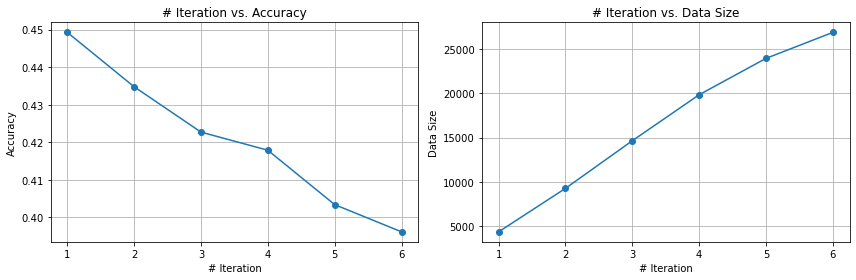

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
axs[0].set_title('# Iteration vs. Accuracy')
axs[0].set_xlabel('# Iteration')
axs[0].set_ylabel('Accuracy')
axs[0].grid()
axs[0].plot([i+1 for i in range(len(accs))], accs, marker='o')
print(data_sizes)
axs[1].set_title('# Iteration vs. Data Size')
axs[1].set_xlabel('# Iteration')
axs[1].set_ylabel('Data Size')
axs[1].grid()
axs[1].plot([i+1 for i in range(len(data_sizes))], data_sizes, marker='o')

In [11]:
from nltk import word_tokenize
print("Reading data")
tarfname = "data/speech.tar.gz"
nltk_speech = read_files(tarfname, preprocessor=Lemmatizer(), tokenizer=word_tokenize)
print(nltk_speech.trainX.shape)

print("Reading unlabeled data")
nltk_unlabeled = read_unlabeled(tarfname, nltk_speech)
print(nltk_unlabeled.X.shape)

Reading data
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
(4370, 9036)
Reading unlabeled data
(43342, 9036)
(43342, 9036)


In [14]:
print("Training classifier")
nltk_clss, nltk_accs, nltk_data_sizes = self_train(
    nltk_unlabeled.X, nltk_speech.trainX, nltk_speech.trainy, nltk_speech.devX, nltk_speech.devy, C=0.5)

Training classifier
1th train
Data size: (4370, 9036) (4370,)
Evaluate Dev
  Accuracy 0.45169082125603865
new best score
Predicting unlabeled data with the previous model
Data added: (4754, 9036)
2th train
Data size: (9124, 9036) (9124,)
Evaluate Dev
  Accuracy 0.4444444444444444
stall 1 times
Predicting unlabeled data with the previous model
Data added: (4935, 9036)
3th train
Data size: (14059, 9036) (14059,)
Evaluate Dev
  Accuracy 0.4396135265700483
stall 2 times
Predicting unlabeled data with the previous model
Data added: (4289, 9036)
4th train
Data size: (18348, 9036) (18348,)
Evaluate Dev
  Accuracy 0.43478260869565216
stall 3 times
Predicting unlabeled data with the previous model
Data added: (3306, 9036)
5th train
Data size: (21654, 9036) (21654,)
Evaluate Dev
  Accuracy 0.4227053140096618
stall 4 times
Predicting unlabeled data with the previous model
Data added: (2408, 9036)
6th train
Data size: (24062, 9036) (24062,)
Evaluate Dev
  Accuracy 0.41545893719806765
stall 5 times

In [42]:
print("Training classifier")
nltk_student_cls, nltk_student_acc, nltk_teacher_cls, nltk_teacher_acc = student_teacher(
    nltk_unlabeled.X, nltk_speech.trainX, nltk_speech.trainy, nltk_speech.devX, nltk_speech.devy)

print("Evaluating")
evaluate(nltk_speech.trainX, nltk_speech.trainy, nltk_student_cls)
evaluate(nltk_speech.devX, nltk_speech.devy, nltk_student_cls)

Training classifier
Train teacher model
Data size: (4370, 9036) (4370,)
Evaluate Dev
  Accuracy 0.45169082125603865
Predicting unlabeled data with the teacher model
(19, 9036) (19,)
(52, 9036) (52,)
(4, 9036) (4,)
(21176, 9036) (21176,)
(1948, 9036) (1948,)
(798, 9036) (798,)
(1221, 9036) (1221,)
(517, 9036) (517,)
(1, 9036) (1,)
(3479, 9036) (3479,)
(9483, 9036) (9483,)
(192, 9036) (192,)
(22, 9036) (22,)
(31, 9036) (31,)
(2293, 9036) (2293,)
(123, 9036) (123,)
(946, 9036) (946,)
(630, 9036) (630,)
(407, 9036) (407,)
Train student model
Data size: (47712, 9036) (47712,)
Evaluate Dev
  Accuracy 0.4323671497584541
Evaluating
  Accuracy 0.8649885583524027
  Accuracy 0.4323671497584541


0.4323671497584541

[4370, 9119, 13917, 18257, 21669, 24086, 25839]


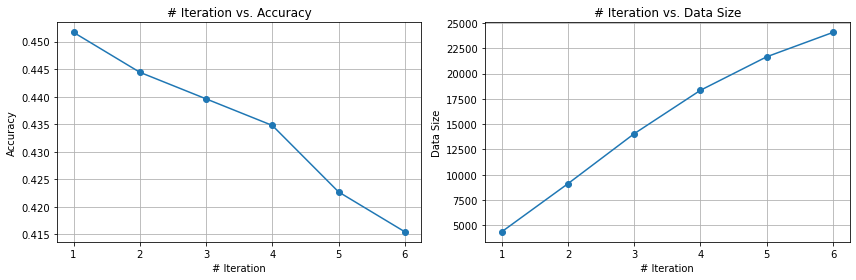

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
axs[0].set_title('# Iteration vs. Accuracy')
axs[0].set_xlabel('# Iteration')
axs[0].set_ylabel('Accuracy')
axs[0].grid()
axs[0].plot([i+1 for i in range(len(nltk_accs))], nltk_accs, marker='o')
print(nltk_data_sizes)
axs[1].set_title('# Iteration vs. Data Size')
axs[1].set_xlabel('# Iteration')
axs[1].set_ylabel('Data Size')
axs[1].grid()
axs[1].plot([i+1 for i in range(len(nltk_data_sizes))], nltk_data_sizes, marker='o')

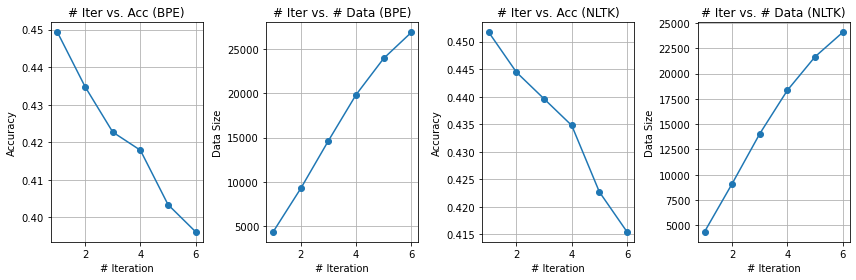

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(12, 4), tight_layout=True)
axs[0].set_title('# Iter vs. Acc (BPE)')
axs[0].set_xlabel('# Iteration')
axs[0].set_ylabel('Accuracy')
axs[0].grid()
axs[0].plot([i+1 for i in range(len(accs))], accs, marker='o')
axs[1].set_title('# Iter vs. # Data (BPE)')
axs[1].set_xlabel('# Iteration')
axs[1].set_ylabel('Data Size')
axs[1].grid()
axs[1].plot([i+1 for i in range(len(data_sizes))], data_sizes, marker='o')


axs[2].set_title('# Iter vs. Acc (NLTK)')
axs[2].set_xlabel('# Iteration')
axs[2].set_ylabel('Accuracy')
axs[2].grid()
axs[2].plot([i+1 for i in range(len(nltk_accs))], nltk_accs, marker='o')
axs[3].set_title('# Iter vs. # Data (NLTK)')
axs[3].set_xlabel('# Iteration')
axs[3].set_ylabel('Data Size')
axs[3].grid()
axs[3].plot([i+1 for i in range(len(nltk_data_sizes))], nltk_data_sizes, marker='o')